In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import argparse
import json
import random
import time

import tqdm
import pickle
from torchvision import datasets, transforms, models
import loader
import models
import numpy as np

import torch
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import unicodedata
import re
import datetime as dt
print(torch.__version__)
import shutil

import nltk
nltk.download('wordnet')
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
% matplotlib inline
#import convlstm

1.0.1.post2


[nltk_data] Downloading package wordnet to /home/skp454/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
UsageError: Line magic function `%` not found.


In [5]:
# Set random seeds
random.seed(7)
torch.manual_seed(7)

In [6]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#device = "cpu"

cuda


In [7]:
with (open('/scratch/skp454/AST/MainDir/data/'+'dictionary.pkl', "rb")) as openfile:
    dictionary = pickle.load(openfile, encoding = 'latin1')

In [8]:
#train_file = '/scratch/skp454/AST/MainDir/data/s_train_set.pkl'
dev_file = '/scratch/skp454/AST/MainDir/data/test_set.pkl'
train_file = '/scratch/skp454/AST/MainDir/data/train_set.pkl'

In [9]:
BATCH_SIZE = 16
units = 256
embedding_dim = 256

In [10]:
# Loaders
#train_ldr = loader.make_loader(train_file, BATCH_SIZE)
dev_ldr = loader.make_loader(dev_file, BATCH_SIZE)

def trans_input(inputs):
    inputs = np.array(inputs)
    inputs = np.swapaxes(inputs,1,3)
    inputs = np.swapaxes(inputs,2,3)
    return torch.Tensor(inputs)

def trans_label(labels):
    labels = np.array(labels)
    #labels = np.swapaxes(labels,1,2)
    return torch.Tensor(labels)

In [11]:
class Encoder(nn.Module):
    def __init__(self, batch_sz, enc_units):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.feature = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=(1,2), padding=0),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=(1,2), padding=0),
            nn.BatchNorm2d(64))
        self.recurrent = nn.Sequential(
            nn.LSTM(4864, self.enc_units, 3, batch_first=True,  bidirectional =False, dropout = 0.5))
        
    def forward(self, x, device):
        x = self.feature(x) 
        self.hidden = self.initialize_hidden_state(device)
        x = x.permute(0,3,1,2)
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3])
        output, self.hidden = self.recurrent(x)
        return output, self.hidden

    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch_sz, self.enc_units)).to(device)

In [12]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, dec_units, enc_units, batch_sz, embedding_dim):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.enc_units = enc_units
        self.recurrent = nn.Sequential(
            nn.LSTM(512, self.enc_units, 3, batch_first=True,  bidirectional =False, dropout = 0.5))
        self.fc = nn.Linear(self.enc_units, self.vocab_size)
        
        # used for attention
        self.W1 = nn.Linear(self.enc_units, self.dec_units)
        self.W2 = nn.Linear(self.enc_units, self.dec_units)
        self.V = nn.Linear(self.enc_units, 1)
    
    def forward(self, x, hidden, enc_output):
        
        hidden_with_time_axis = hidden.permute(1, 0, 2)[:,2,:].unsqueeze(1)
        score = torch.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis))
        
        #score = torch.tanh(self.W2(hidden_with_time_axis) + self.W1(enc_output))
        # attention_weights shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = torch.softmax(self.V(score), dim=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = torch.sum(context_vector, dim=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = x.type(torch.cuda.LongTensor)
        x = x.unsqueeze(1)
        x = x.to(device)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        #x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # ? Looks like attention vector in diagram of source
        x = torch.cat((context_vector.unsqueeze(1), x), -1)
        
        # passing the concatenated vector to the GRU
        # output: (batch_size, 1, hidden_size)
        output, [state, cell] = self.recurrent(x)
        
        
        # output shape == (batch_size * 1, hidden_size)
        output =  output.view(-1, output.size(2))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        x = torch.softmax(x, dim=1)
        return x, state, attention_weights
    
    def initialize_hidden_state(self):
        return torch.zeros((1, self.batch_sz, self.dec_units))

In [13]:
criterion = nn.CrossEntropyLoss()

def loss_function(real, pred):
    """ Only consider non-zero inputs in the loss; mask needed """
    #mask = 1 - np.equal(real, 0) # assign 0 to all above 0 and 1 to all 0s
    #print(mask)
    mask = real.ge(1).type(torch.cuda.FloatTensor)
    real = real.type(torch.cuda.LongTensor)
#     mask = real.ge(1).type(torch.FloatTensor)
#     real = real.type(torch.LongTensor)
    loss_ = criterion(pred, real) * mask 
    
    return torch.mean(loss_)
    

In [14]:
# function to load model
def load_model(model, model_path, use_cuda=False):
    """Load model."""
    map_location = 'cpu'
    if use_cuda and torch.cuda.is_available():
        map_location = 'cuda:0'
    model.load_state_dict(torch.load(model_path, map_location))
    return model

In [15]:
## TODO: Combine the encoder and decoder into one class
encoder = Encoder(BATCH_SIZE, units)
decoder = Decoder(len(dictionary.keys())+1, units, units, BATCH_SIZE, embedding_dim)

encoder.to(device)
decoder.to(device)

encoder.load_state_dict(torch.load('/scratch/skp454/AST/MainDir/models/13_encoder.pth.tar', device)['state_dict'])
decoder.load_state_dict(torch.load('/scratch/skp454/AST/MainDir/models/13_decoder.pth.tar', device)['state_dict'])

In [16]:
### Evaluation on dev_set
encoder.eval()
decoder.eval()
dev_total_loss = 0
predict = []
with torch.no_grad():
    for inputs, labels in dev_ldr:
        inputs, labels = trans_input(inputs).to(device), trans_label(labels).to(device)
        loss = 0
        enc_output, [enc_hidden, enc_cell] = encoder(inputs.to(device), device)
        del inputs
        del enc_cell
        dec_hidden = enc_hidden
        del enc_hidden
        dec_input = labels[:,0]
        lis = []

        for t in range(1, labels.size(1)):
            predictions, dec_hidden, _ = decoder(dec_input.to(device), 
                                                 dec_hidden.to(device), 
                                                 enc_output.to(device))
            del dec_input
            loss += loss_function(labels[:,t], predictions.to(device))
            dec_input = labels[:,t]

            lis.append(np.array([np.array(labels[:,t].cpu()),\
                             list(np.array(predictions.max(1)[1].cpu()))]))
        predict.append(lis)
        clear_output()
        print(len(predict))
        dev_batch_loss = (loss / int(labels.size(1)))
        dev_total_loss += dev_batch_loss


335


In [17]:
predict = np.array(predict)
predict = np.swapaxes(predict, 1, 3)

In [18]:
predict.shape

(335, 16, 2, 18)

In [19]:
# prepare invesrion dictionary
map_dict = dict([[v,k] for k,v in dictionary.items()])           

In [20]:
def cleanit(text, word):
    text1 = text
    run = True
    while run:
        try:
            text1.remove(word)
        except:
            run = False
    run = True
    return text1

In [21]:
pairs = []
for i in range(predict.shape[0]):
    for j in range(predict.shape[1]):
        true = list(map(map_dict.get, list(predict[i][j][0])))
        true = cleanit(true, '_')
        true = cleanit(true, '</s>')
        pred = list(map(map_dict.get, list(predict[i][j][1])))
        pred = cleanit(pred, '_')
        pred = cleanit(pred,'</s>')
        pairs.append([true, pred])


In [98]:
from nltk.translate.bleu_score import sentence_bleu
score = []
for i in pairs:    
    score.append(sentence_bleu([i[0]], i[1], weights=(1, 0, 0, 0)))
    #score.append(sentence_bleu([i[0]], i[1]))

/home/skp454/bigdata/bdpy/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/skp454/bigdata/bdpy/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/skp454/bigdata/bdpy/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or

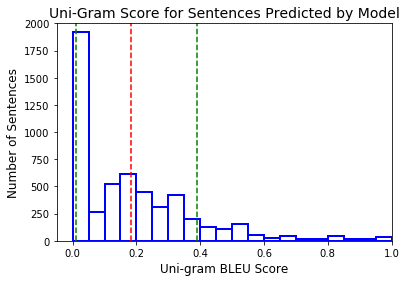

In [158]:
plt.hist(score, bins =20 ,histtype= 'bar',  edgecolor='blue', color='white', linewidth=2.0)
plt.xlabel("Uni-gram BLEU Score", fontsize = 12)
plt.ylabel("Number of Sentences", fontsize = 12)
plt.vlines(np.mean(score),0,2000, linestyles = 'dashed', color = 'red')
plt.vlines(0.01 ,0,2000, linestyles = 'dashed', color = 'green')
plt.vlines(0.39 ,0,2000, linestyles = 'dashed', color = 'green')
plt.xlim(-0.05,1)
plt.ylim(0,2000)
plt.title('Uni-Gram Score for Sentences Predicted by Model', fontsize = 14)
plt.savefig('hist1.png')